In [22]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.visualize import *
from src.models.train_model import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# RF Optimization

In [8]:
data = Dataset('Chiang Mai')
data.load_()
data.pollutant = 'PM2.5'
# build the first dataset 
data.feature_no_fire()
data.make_diff_col()
# use default fire feature
data.merge_fire()
x_cols = data.data.columns.drop([data.pollutant, data.monitor ] )
print(x_cols)

data no fire has shape (77746, 15)
use default fire feature
Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')


{'n_estimators': 160, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 2, 'max_depth': None, 'bootstrap': False} 0.01369357440798844
optimize 1 score {'val_r2_score': 0.05221266883633913, 'val_mean_squared_error': 40.18064965483873}


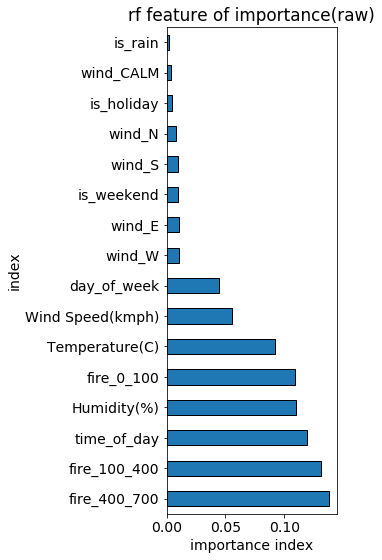

In [38]:
print('=================optimize 1: find the best RF model=================')
data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=x_cols)
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=x_cols)
data.x_cols = x_cols

model = do_rf_search(xtrn,ytrn)
score_dict = cal_scores(yval, model.predict(xval), header_str ='val_')
print('optimize 1 score', score_dict)

importances = model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()
show_fea_imp(feat_imp, title='rf feature of importance(raw)')


In [39]:
print('=================optimize 2: remove unncessary columns=================')
# columns to consider droping are columns with low importance
to_drop = feat_imp['index']
to_drop = [a for a in to_drop if 'fire' not in a]

for s in ['Humidity(%)','Temperature(C)','Wind Speed(kmph)']:
    to_drop.remove(s)

to_drop.reverse()
model, new_x_cols = reduce_cols(dataset=data,x_cols=x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
data.x_cols = new_x_cols

=================optimize 2: remove unncessary columns=================
old cols Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')
drop wind_W
use columns Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'is_rain', 'is_holiday', 'is_weekend',
       'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000'],
      dtype='object')
r2_score after dropping columns 0.05239219230489467


In [40]:
print('================= optimization 3: find the best fire feature ===================')
# reduce the number of split
data.split_data(split_ratio=[0.6, 0.2, 0.2])
data.fire_dict = sk_op_fire(data, model, trn_index=data.split_list[0], val_index=data.split_list[1])
print(data.fire_dict)

================= optimization 3: find the best fire feature ===================
skop_ fire use x_cols Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'is_rain', 'is_holiday', 'is_weekend',
       'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000'],
      dtype='object')
old score 0.05122011519965075 fire dict {'w_speed': 4, 'shift': -24, 'roll': 108}
optimizing fire parameter using skopt optimizer. This will take about 20 mins
r2 score for the best fire parameters 0.05872747338753381


In [42]:
print('================= optimization 4: optimize for the best RF again and search for other model in TPOT =================')

data.split_data(split_ratio=[0.7, 0.3])
trn_index = data.split_list[0]
test_index = data.split_list[1]
fire_cols = data.merge_fire(data.fire_dict)
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=trn_index,x_cols=new_x_cols)
xtest, ytest, _ = data.get_data_matrix(use_index=test_index,x_cols=new_x_cols)

print('optimize RF')
rf_model = do_rf_search(xtrn,ytrn)
rf_score_dict = cal_scores(ytest, rf_model.predict(xtest), header_str ='test_')
print(rf_score_dict)
rf_dict = rf_model.get_params()

================= optimization 4: optimize for the best RF again and search for other model in TPOT =================
optimize RF
{'n_estimators': 140, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 2, 'max_depth': None, 'bootstrap': True} 0.033492815495902814
{'test_r2_score': 0.12367580769263986, 'test_mean_squared_error': 24.0925587145206}


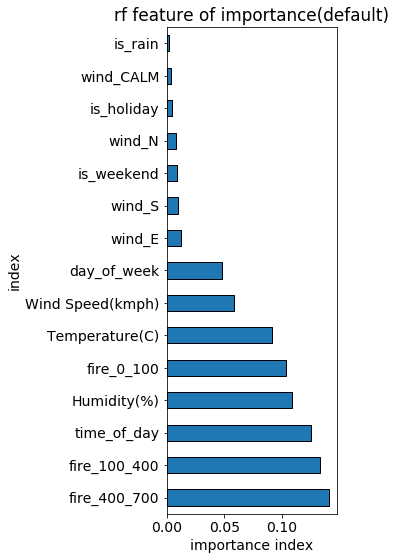

In [43]:
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()
show_fea_imp(feat_imp, title='rf feature of importance(default)')

# Model Performance

In [11]:
data = Dataset('Chiang Mai')
data.load_()
data.pollutant = 'PM2.5'
# build the first dataset 
data.feature_no_fire()
data.make_diff_col()

data no fire has shape (77746, 15)


In [12]:
data.fire_dict = {'w_speed': 2, 'shift': -48, 'roll': 26}


In [14]:
# use default fire feature
data.merge_fire()
x_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'is_rain', 'is_holiday', 'is_weekend',
       'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000']
print(data.start_value)

use default fire feature
1.0


In [3]:
model = RandomForestRegressor(**{'n_estimators': 140, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 2, 'max_depth': None, 'bootstrap': True})

In [15]:
data.split_data(split_ratio=[0.7, 0.3])
trn_index = data.split_list[0]
test_index = data.split_list[1]
fire_cols = data.merge_fire(data.fire_dict)
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=trn_index,x_cols=x_cols)
xtest, ytest, _ = data.get_data_matrix(use_index=test_index,x_cols=x_cols)


In [16]:
model.fit(xtrn, ytrn)
ytrn_pred = model.predict(xtrn)
ytest_pred = model.predict(xtest)

In [20]:
ytrn_pred.shape

(54421,)

Text(0, 0.5, 'PM2.5')

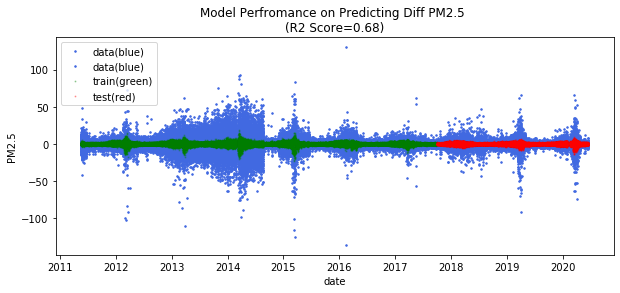

In [19]:
plt.figure(figsize=(10, 4))

# plot data 
plt.plot(trn_index,ytrn, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')
plt.plot(test_index,ytest, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')

plt.plot(trn_index,ytrn_pred, marker='.', label='train(green)',linewidth=0,alpha=0.3, markersize=2,color='green')
plt.plot(test_index,ytest_pred, marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')
 
plt.legend()
plt.title('Model Perfromance on Predicting Diff PM2.5 \n(R2 Score=0.68)')
plt.xlabel('date')
plt.ylabel('PM2.5')

Text(0, 0.5, 'PM2.5')

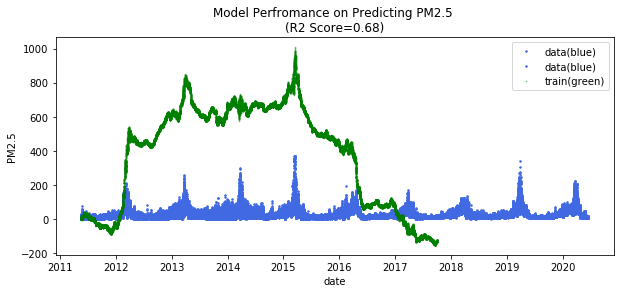

In [25]:
plt.figure(figsize=(10, 4))

# plot data 
plt.plot(trn_index,data_df.loc[trn_index,data.pollutant], marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')
plt.plot(test_index,data_df.loc[test_index,data.pollutant], marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')

plt.plot(trn_index,ytrn_pred.cumsum() + data.start_value, marker='.', label='train(green)',linewidth=0,alpha=0.3, markersize=2,color='green')
#plt.plot(test_index,rf_model.predict(xtest), marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')
 
plt.legend()
plt.title('Model Perfromance on Predicting PM2.5 \n(R2 Score=0.68)')
plt.xlabel('date')
plt.ylabel('PM2.5')

In [30]:
fire_df = data.fire.groupby(level=0).sum()
fire_df = fire_df.resample('h').sum()
fire_df.head()

,confidence,lat_km,long_km,distance,power,count
datetime,,,,,,
2002-07-04 13:00:00,1402,55794,271000,19585.707489,592.147,23
2002-07-04 14:00:00,0,0,0,0.000000,0.000,0
2002-07-04 15:00:00,0,0,0,0.000000,0.000,0
2002-07-04 16:00:00,0,0,0,0.000000,0.000,0
2002-07-04 17:00:00,0,0,0,0.000000,0.000,0


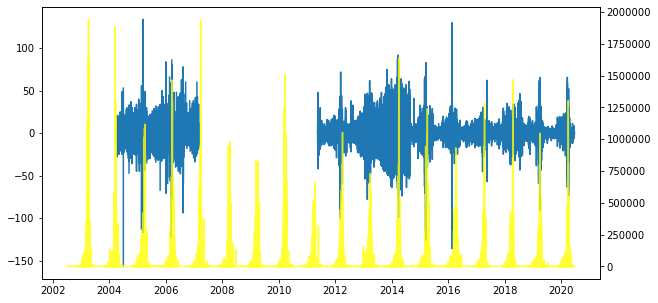

In [39]:
_, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(data.poll_df['PM2.5'].diff())
a = ax.twinx()
a.plot(fire_df['power'],color='yellow',alpha=0.8)

#ax.set_xlim(['2018-01-01','2020-06-01'])

# RF + Lagging

In [104]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

In [4]:
def get_lag(x_cols, n):
    """Obtain lagged value of x_cols return just the lagged df
    
    """
    lag_df = data_df[x_cols].shift(n)
    lag_df.columns = [ s+ f'_lag_{n}' for s in lag_df.columns]  
    return lag_df

In [106]:
data = Dataset('Chiang Mai')
data.load_()
data.monitor  = data.pollutant = 'PM2.5'
# build the first dataset 
data.feature_no_fire()
data.fire_dict = {'w_speed': 20, 'shift': -18, 'roll': 120}
# use default fire feature
data.merge_fire()
x_cols = data.data.columns.drop([data.pollutant, data.monitor, 'PM2.5_lag_1' ] )
print(x_cols)
# drop the PM2.5 lag columns
data_df_backup = data.data.copy()
data_df_backup = data_df_backup.drop('PM2.5_lag_1', axis=1)
data_df_backup.shape

data no fire has shape (77746, 15)
use default fire feature
Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')


(77746, 18)

In [36]:
print('=================optimize 1: find the best RF model=================')
data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=x_cols)
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=x_cols)
data.x_cols = x_cols

m = ExtraTreesRegressor(n_jobs=-1, random_state=42)
m.fit(xtrn,ytrn)
score_dict = cal_scores(yval, m.predict(xval), header_str ='val_')
print(score_dict)

=================optimize 1: find the best RF model=================
{'val_r2_score': 0.5685401257782331, 'val_mean_squared_error': 515.6143388770981, 'val_mean_absolute_error': 13.294085793298605}


In [77]:
score_df = []
for max_n in tqdm_notebook(np.arange(17, 21, 1)):
    x_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)',
       'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain',
       'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000']
    data_df = data_df_backup
    
    lag_list = [data_df]
    for n in np.arange(1,max_n):
        lag_df = get_lag(x_cols, n)
        lag_list.append(lag_df)
        
    data_df = pd.concat(lag_list, axis=1, ignore_index=False)
    data.data = data_df.dropna()
 
    data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
    xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
    xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])
    print(xtrn.shape)
    data.x_cols = x_cols

    m = ExtraTreesRegressor(n_jobs=-1, random_state=42)
    m.fit(xtrn,ytrn)
    score_dict = cal_scores(yval, m.predict(xval), header_str ='val_')
    score_df.append(pd.DataFrame(score_dict,index=[max_n]))
    
score_df = pd.concat(score_df)
score_df.sort_values('val_mean_absolute_error') 

(31092, 289)
(31091, 306)
(31091, 323)
(31090, 340)



AttributeError: 'DataFrame' object has no attribute 'sort_value'

In [107]:
max_n = 18

x_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)',
       'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain',
       'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000']

data_df = data_df_backup
    
lag_list = [data_df]
for n in np.arange(1,max_n):
    lag_df = get_lag(x_cols, n)
    lag_list.append(lag_df)
        
data_df = pd.concat(lag_list, axis=1, ignore_index=False)
data.data = data_df.dropna()
 
data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])
print(xtrn.shape)
data.x_cols = x_cols


(31091, 306)


In [108]:
print('=================optimize 1: find the best RF model=================')

m = ExtraTreesRegressor(n_jobs=-1, random_state=42)
m.fit(xtrn,ytrn)
score_dict = cal_scores(yval, m.predict(xval), header_str ='val_')
print(score_dict)

=================optimize 1: find the best RF model=================
{'val_r2_score': 0.5966005292987893, 'val_mean_squared_error': 482.21817725099174, 'val_mean_absolute_error': 13.151741181516028}


In [ ]:
print('=================optimize 1: find the best RF model=================')
model = do_rf_search(xtrn,ytrn)
score_dict = cal_scores(yval, model.predict(xval), header_str ='val_')
print('optimize 1 score', score_dict)

importances = model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()
#show_fea_imp(feat_imp, title='rf feature of importance(raw)')

=================optimize 1: find the best RF model=================


In [ ]:
print('=================optimize 2: remove unncessary columns=================')

# columns to consider droping are columns with low importance
to_drop = feat_imp['index']
to_drop = [a for a in to_drop if 'fire' not in a]
for s in ['Humidity(%)','Temperature(C)','Wind Speed(kmph)']:
        to_drop.remove(s)
    to_drop.reverse()
    model, new_x_cols = reduce_cols(dataset=data,x_cols=x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
    data.x_cols = new_x_cols

# Compare Different of models

In [93]:
# prepare a list of ml models
def get_models(models=dict()):
    # non-linear models
    models['knn'] = KNeighborsRegressor(n_neighbors=7)
     
    models['extra'] = ExtraTreeRegressor()
   
    # # ensemble models
    n_trees = 100
    models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bag'] = BaggingRegressor(n_estimators=n_trees)
    models['rf'] = RandomForestRegressor(n_estimators=n_trees)
    models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
    
    models['svmr'] = SVR()
    
    return models

In [94]:
models = get_models()

model_search_df = []
for k, model in models.items():
    model.fit(xtrn,ytrn)
    score_dict = cal_scores(yval, model.predict(xval), header_str ='val_')
    score_dict['model'] = k
    print(score_dict)
    model_search_df.append(pd.DataFrame(score_dict, index=[0]))
    
model_search_df  = pd.concat(model_search_df, ignore_index=True)
model_search_df.sort_values('val_mean_absolute_error')

{'val_r2_score': 0.5983752033937699, 'val_mean_squared_error': 480.0967562540616, 'val_mean_absolute_error': 12.951603639204153, 'model': 'knn'}
{'val_r2_score': 0.3077305706507292, 'val_mean_squared_error': 827.5293515063794, 'val_mean_absolute_error': 18.713053500589687, 'model': 'extra'}
{'val_r2_score': 0.1528640537993985, 'val_mean_squared_error': 1012.6546550756847, 'val_mean_absolute_error': 26.661358498228136, 'model': 'ada'}
{'val_r2_score': 0.5796934685803758, 'val_mean_squared_error': 502.42864502412345, 'val_mean_absolute_error': 13.30477388227726, 'model': 'bag'}
{'val_r2_score': 0.5762734576088353, 'val_mean_squared_error': 506.5168790865229, 'val_mean_absolute_error': 13.323806154176047, 'model': 'rf'}
{'val_r2_score': 0.5899842409338647, 'val_mean_squared_error': 490.1271973346199, 'val_mean_absolute_error': 13.170514206068404, 'model': 'et'}
{'val_r2_score': 0.5951410603800058, 'val_mean_squared_error': 483.96280631693196, 'val_mean_absolute_error': 12.180557233448726,

,val_r2_score,val_mean_squared_error,val_mean_absolute_error,model
7,0.530902,560.752707,11.848127,svmr
6,0.595141,483.962806,12.180557,gbm
0,0.598375,480.096756,12.951604,knn
5,0.589984,490.127197,13.170514,et
3,0.579693,502.428645,13.304774,bag
4,0.576273,506.516879,13.323806,rf
1,0.307731,827.529352,18.713054,extra
2,0.152864,1012.654655,26.661358,ada


# Useing RF

In [12]:
data = Dataset('Chiang Mai')
data.load_()
data.monitor  = data.pollutant = 'PM2.5'
# build the first dataset 
data.feature_no_fire()
data.fire_dict = {'w_speed': 20, 'shift': -18, 'roll': 120}
# use default fire feature
data.merge_fire(data.fire_dict)
x_cols = data.data.columns.drop([data.pollutant, data.monitor, 'PM2.5_lag_1' ] )
print(x_cols)
# drop the PM2.5 lag columns
data.data_back = data.data.copy().drop('PM2.5_lag_1', axis=1)
data.data_back.head()
data.x_cols_back = x_cols

data no fire has shape (77746, 15)
Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')


In [17]:
data.build_lag(max_n = 18)

data.split_data(split_ratio=[0.3, 0.25, 0.25, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])
print(xtrn.shape)
data.x_cols = x_cols

(23299, 306)


In [18]:
print('=================optimize 1: find the best knn model=================')

model = ExtraTreesRegressor()
model.fit(xtrn,ytrn)
score_dict = cal_scores(yval, model.predict(xval), header_str ='val_')
print('optimize 1 score', score_dict) 

=================optimize 1: find the best knn model=================
optimize 1 score {'val_r2_score': 0.5388482407514033, 'val_mean_squared_error': 580.7507219664195, 'val_mean_absolute_error': 15.157248145859086}


In [ ]:
importances = model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()

# columns to consider droping are columns with low importance
to_drop = feat_imp['index'].to_list()

no_drop = ['Humidity(%)','Temperature(C)','Wind Speed(kmph)'] + [a for a in data.x_cols_back if 'fire' in a]

for s in  no_drop:
    to_drop.remove(s)
    
to_drop.reverse()
model, new_x_cols = reduce_cols(dataset=data,x_cols=x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
data.x_cols = new_x_cols

old cols length 306
drop is_rain_lag_3
drop is_rain_lag_13
drop is_rain_lag_12
drop is_rain
drop is_rain_lag_10
drop is_rain_lag_14
drop is_rain_lag_8
drop is_rain_lag_7
drop is_rain_lag_6
drop is_rain_lag_4
drop is_rain_lag_17
drop is_rain_lag_5
drop is_holiday_lag_8
drop is_holiday_lag_7
drop is_holiday_lag_16
drop is_holiday_lag_14
drop is_holiday_lag_6


In [ ]:
print('==========optimize fire featuree====')
x_cols = dataset.x_cols
data.split_data(split_ratio=[0.5, 0.3, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])

model.fit(xtrn,ytrn)
best_score = mean_absolute_error(yval,model.predict(xval))
best_fire_dict = dataset.fire_dict
print('old score', best_score, 'fire dict', best_fire_dict)

print('optimizing fire parameter using skopt optimizer. This will take about 20 mins')
# build search space 
wind_speed = Real(low=wind_range[0], high=wind_range[1], name='wind_speed')
shift = Integer(low=shift_range[0], high=shift_range[1], name='shift')
roll = Integer(low=roll_range[0],high=roll_range[1], name='roll')

dimensions = [wind_speed, shift, roll]
# setup the function for skopt
@use_named_args(dimensions)
def fit_with( wind_speed, shift, roll):
    # function to return the score (smaller better)
    fire_dict = { 'w_speed': wind_speed, 
                      'shift': shift,
                      'roll': roll}
    
    _ = dataset.merge_fire(fire_dict)
    data.data_back = data.data.copy().drop('PM2.5_lag_1', axis=1)
    
    xtrn, ytrn, x_cols = dataset.get_data_matrix(use_index= trn_index, x_cols=dataset.x_cols)
    xval, yval, _ = dataset.get_data_matrix(use_index=val_index, x_cols=dataset.x_cols)
    
    model.fit(xtrn,ytrn)
    y_pred = model.predict(xval)
    
    return mean_absolute_error(yval,y_pred)

gp_result = gp_minimize(func=fit_with,dimensions=dimensions,n_jobs=-1,random_state=30)
    
wind_speed, shift, roll = gp_result.x
score = gp_result.fun

In [ ]:
fire_dict =  {'w_speed': int(wind_speed), 'shift': int(shift), 'roll': int(roll)}
print(fire_dict)